In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import seaborn as sns
import statsmodels.formula.api as smf
import ratmetab
import itertools
import re
if os.getlogin() == 'jonesa7':
    import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if os.getlogin() == 'jonesa7':
    codebookpath = '../../resources/rat-metabolites/Rat_codebook_27_Oct_2022.csv'
    datapath = {
        'blood new': 'blood_27_Oct_2022',
        'brain new': 'brain_27_Oct_2022',
        'blood old': 'old_blood_17_Nov_2022',
        'brain old': 'old_brain_17_Nov_2022',
               }
    data = {k: ratmetab.read_data('../../resources/rat-metabolites/Rat_' + v + '.csv', codebookpath, liberal_filter=True) for k, v in datapath.items()}
else:
    datapath_blood = 'some/path'
    datapath_brain = 'some/path'
    codebookpath = 'some/path'

data.update({tissue: pd.concat([data[tissue + ' new'], data[tissue + ' old']], axis=0, join='outer') for tissue in ['blood', 'brain']})

def insert_centered_LIscore(dataset, data=data):
    df = data[dataset]
    s = df.LIscore - df.LIscore.mean()
    val = pd.concat([pd.DataFrame({'LIscore cent.': s}, index=df.index), df], axis=1)
    return(val)

def insert_age(dataset, data=data):
    df = data[dataset]
    l = [(lambda g: 'Y' if g == 'Y' else 'A')(group) for group in df.Group]
    val = pd.concat([pd.DataFrame({'Age': l}, index=df.index), df], axis=1)
    return(val)

data = {dataset: insert_age(dataset, data=data) for dataset in data.keys()}
data = {dataset: insert_centered_LIscore(dataset, data=data) for dataset in data.keys()}

In [3]:
fpath = '../../results/2022-11-09-rat-metabolites/summary.csv'
summary = pd.read_csv(fpath, index_col=0)
summary

,Dataset,Comparison,Analyte class,Metabolite,Effect size,"""- log p""",p,Corrected p,Reject H0,Bonferroni alpha,Direction of change,Rank
Phosphatidylcholine aa C40:5,blood new,AI vs. AU,Phosphatidylcholines,Phosphatidylcholine aa C40:5,-0.656900,1.831301,0.014747,0.769241,False,0.000174,Decrease,1
Linolenic acid,blood new,AI vs. AU,Free_Fatty_Acids,Linolenic acid,-0.442021,1.707973,0.019590,0.769241,False,0.000174,Decrease,2
"5-beta,6-beta-Epoxycholesterol",blood new,AI vs. AU,Free_Oxysterols,"5-beta,6-beta-Epoxycholesterol",-1.162864,1.677275,0.021024,0.769241,False,0.000174,Decrease,3
Spermine,blood new,AI vs. AU,Amino_Acids_and_Biogenic_Amines,Spermine,0.550324,1.646695,0.022558,0.769241,False,0.000174,Increase,4
trans-4-Hydroxyproline,blood new,AI vs. AU,Amino_Acids_and_Biogenic_Amines,trans-4-Hydroxyproline,0.969954,1.588279,0.025806,0.769241,False,0.000174,Increase,5
...,...,...,...,...,...,...,...,...,...,...,...,...
Phosphatidylcholine ae C36:4,brain,AU vs. Y,Phosphatidylcholines,Phosphatidylcholine ae C36:4,0.007427,0.010128,0.976949,0.988861,False,0.000198,Increase,248
Docosapentaenoic acid (DPA),brain,AU vs. Y,Free_Fatty_Acids,Docosapentaenoic acid (DPA),-0.012469,0.009134,0.979188,0.988861,False,0.000198,Decrease,249
Leucine,brain,AU vs. Y,Amino_Acids_and_Biogenic_Amines,Leucine,-0.002016,0.008325,0.981013,0.988861,False,0.000198,Decrease,250
Sphingomyelin C18:0,brain,AU vs. Y,Sphingomyelins,Sphingomyelin C18:0,-0.001245,0.001622,0.996273,0.997424,False,0.000198,Decrease,251


Top 10 metabolites for the AI vs. AU comparison in the blood data set

In [4]:
top10 = summary.loc[(summary.Dataset == 'blood') & (summary.Comparison == 'AI vs. AU') & (summary.Rank <= 16), 'Metabolite'].to_list()
top10

['Phosphatidylcholine aa C40:5',
 'Phosphatidylcholine aa C40:4',
 '24,25-Epoxycholesterol',
 '24,25-Dihydrolanosterol',
 'Desmosterol',
 '5-beta,6-beta-Epoxycholesterol',
 'Dihydroceramide C22:0',
 'Phosphatidylcholine aa C42:4',
 'Phosphatidylcholine aa C42:5',
 'Phosphatidylcholine ae C42:2',
 'Phosphatidylcholine aa C40:2',
 'Hydroxysphingomyelin C14:1',
 'Phosphatidylcholine aa C38:3',
 'Spermine',
 'Phosphatidylcholine aa C42:6',
 '7-alpha-Hydroxycholesterol']

Text(0, 0.5, 'LIscore')

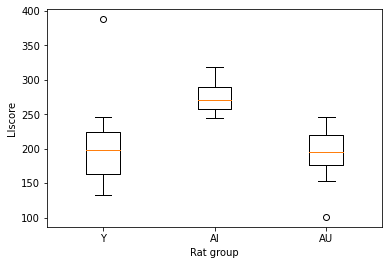

In [5]:
df = data['blood']
d = {group: df.loc[df.Group == group, 'LIscore'] for group in ['Y', 'AI', 'AU']}
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_xlabel('Rat group')
ax.set_ylabel('LIscore')

Text(0, 0.5, 'LIscore')

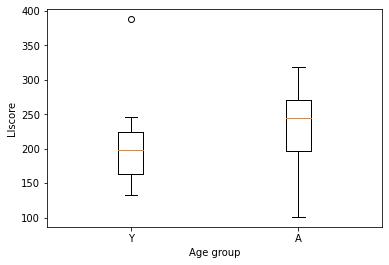

In [6]:
df = data['blood']
d = {group: df.loc[df.Age == group, 'LIscore'] for group in ['Y', 'A']}
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_xlabel('Age group')
ax.set_ylabel('LIscore')

In [7]:
def metab_LI_scatter(metabolite, dataset, data=data):
    df = data[dataset]
    dat = df.loc[df.Group.isin(['AI', 'AU']), ['LIscore', metabolite]]
    fig, ax = plt.subplots()
    sns.regplot(x='LIscore', y=metabolite, data=dat, ax=ax)
    #ax.scatter(x='LIscore', y=metabolite, data=dat)
    ax.set_xlabel('LIscore')
    ax.set_ylabel('metabolite level')
    ax.set_title(metabolite)
    return((fig, ax))

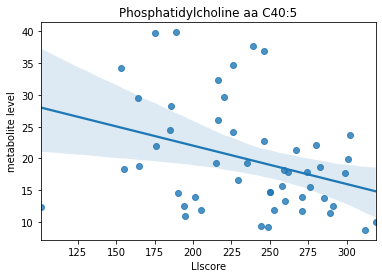

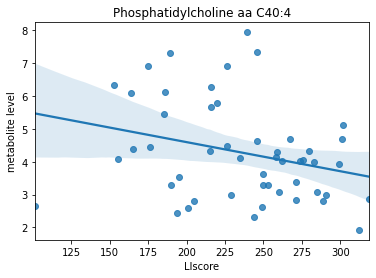

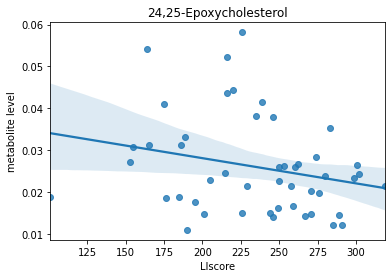

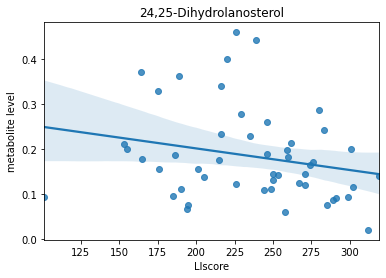

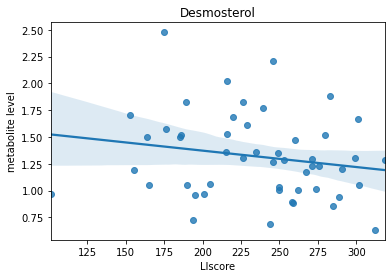

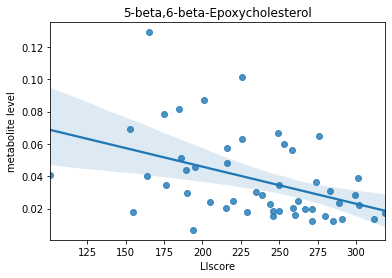

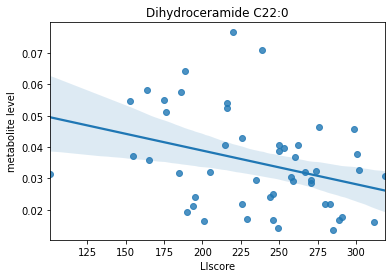

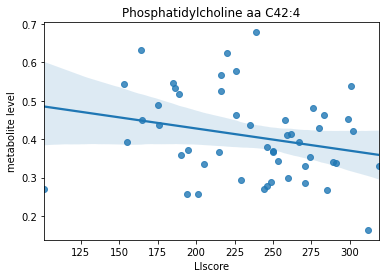

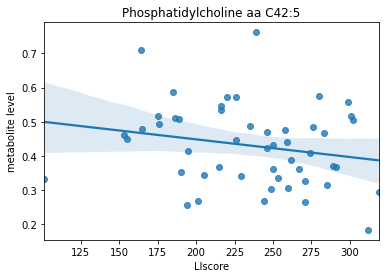

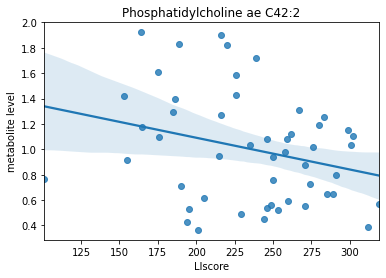

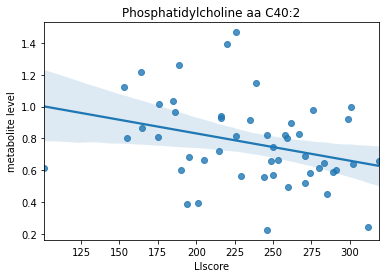

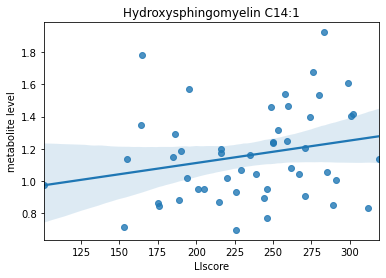

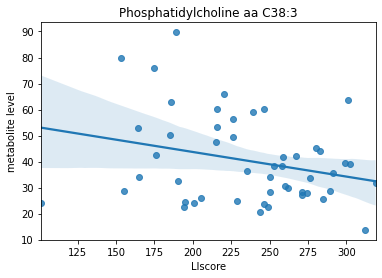

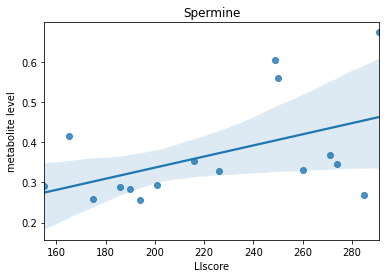

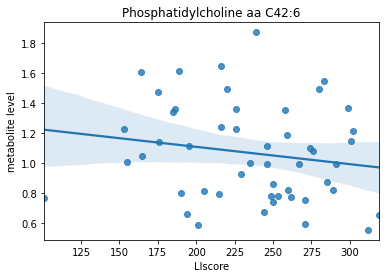

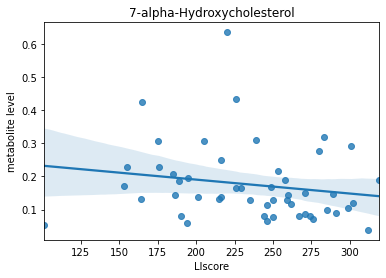

In [8]:
for metabolite in top10:
    fig, ax = metab_LI_scatter(metabolite, 'blood')

total variance = explained variance + unexplained variance

R^2 = (total variance - unexplained variance) / explained variance

## Designing linear models

### Model $M$: baseline age: aged, A

Formula `f1 = Q("Phosphatidylcholine aa C40:5") ~ Age + LIscore + Age:LIscore`

Equation:
$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i3} + \epsilon_i,
\hspace{2em}
i = 1,...,n=75
$

where
* $y$: Phosphatidylcholine aa C40:5 level
* $\beta_0$: intercept
* $\beta_1 x_{i1}$: effect of age, relative to A (aged)
* $\beta_2 x_{i2}$: interpretation?
* $\beta_3 x_{i1} x_{i2}$: interpretation?

### Model $M'$: baseline age: young, Y

Formula `f2 = Q("Phosphatidylcholine aa C40:5") ~ C(Age, levels=["Y", "A"]) + LIscore + Age:LIscore`

Equation:
$
y_i = \beta_0' + \beta_1' x_{i1}' + \beta_2' x_{i2} + \beta_3' x_{i1}' x_{i2} + \epsilon_i,
\hspace{2em}
i = 1,...,n=75
$

* $y_i$: Phosphatidylcholine aa C40:5 level
* $\beta_0'$: intercept
* $\beta_1' x_{i1}'$: effect of age, relative to Y (young)
* $\beta_2' x_{i2}$: interpretation?
* $\beta_3' x_{i1}' x_{i2}$: interpretation?

#### Note

1. If rat $i$ is Y (young):
    * $\beta_1 x_{i1} = \beta_1$ and $\beta_3 x_{i1} x_{i2} = \beta_3 x_{i2}$ for $M$
    * $\beta_1' x_{i1}' = 0$ and $\beta_3' x_{i1}' x_{i2} = 0$ for $M'$
1. If rat $i$ is A (aged):
    * $\beta_1 x_{i1} = 0$ and $\beta_3 x_{i1} x_{i2} = 0$ for $M$
    * $\beta_1' x_{i1}' = 1$ and $\beta_3' x_{i1}' x_{i2} = \beta_3' x_{i2}$ for $M'$

## Fitting linear models

In [9]:
dataset = 'blood'
metabolite = 'Phosphatidylcholine aa C40:5'
f1 = 'Q("' + metabolite + '")' + ' ~ Age * LIscore'
f2 = 'Q("' + metabolite + '")' + ' ~ C(Age, levels=["Y", "A"]) * LIscore'
f3 = 'Q("' + metabolite + '")' + ' ~ Age * Q("LIscore cent.")'
f4 = 'Q("' + metabolite + '")' + ' ~ Age + Age : Q("LIscore cent.")'
f5 = 'Q("' + metabolite + '")' + ' ~ C(Age, levels=["Y", "A"]) * Q("LIscore cent.")'
df = data[dataset]
result1, result2, result3, result4, result5 = [smf.ols(f, data=df).fit() for f in [f1, f2, f3, f4, f5]]

### Model $M_1$

* reference age: aged, A

We quantify the effect of young, Y rats with respect to aged, A, rats.

In [10]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 22 Dec 2022   Prob (F-statistic):           8.92e-06
Time:                                       21:55:50   Log-Likelihood:                -248.75
No. Observations:                                 75   AIC:                             505.5
Df Residuals:                                     71   BIC:                             514.8
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           34.1235      4.883      6.989      0.000      24.387      43.859
Age[T.Y]           -22.9450      7.590     -3.023      0.003     -38.080      -7.810
LIscore             -0.0605      0.020     -2.970      0.004      -0.101      -0.020
Age[T.Y]:LIscore     0.0642      0.035      1.860      0.067      -0.005       0.133
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                     2.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model $M_2$

* reference age: young, Y

We quantify the effect of aged, A rats with respect to young, Y, rats.

In [11]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 22 Dec 2022   Prob (F-statistic):           8.92e-06
Time:                                       21:55:50   Log-Likelihood:                -248.75
No. Observations:                                 75   AIC:                             505.5
Df Residuals:                                     71   BIC:                             514.8
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 11.1785      5.811      1.924      0.058      -0.409      22.766
C(Age, levels=["Y", "A"])[T.A]            22.9450      7.590      3.023      0.003       7.810      38.080
LIscore                                    0.0038      0.028      0.135      0.893      -0.052       0.059
C(Age, levels=["Y", "A"])[T.A]:LIscore    -0.0642      0.035     -1.860      0.067      -0.133       0.005
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                     3.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model $M_3$:

* reference age: aged, A
* centered LIscore

In [12]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 22 Dec 2022   Prob (F-statistic):           8.92e-06
Time:                                       21:55:50   Log-Likelihood:                -248.75
No. Observations:                                 75   AIC:                             505.5
Df Residuals:                                     71   BIC:                             514.8
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      20.5666      0.995     20.679      0.000      18.583      22.550
Age[T.Y]                       -8.5428      1.799     -4.748      0.000     -12.131      -4.955
Q("LIscore cent.")             -0.0605      0.020     -2.970      0.004      -0.101      -0.020
Age[T.Y]:Q("LIscore cent.")     0.0642      0.035      1.860      0.067      -0.005       0.133
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                         132.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model $M_4$:

* no reference age: the effect of LIscore is estimated separately in
    1. young, Y rats
    1. aged, A rats
* centered LIscore

In [13]:
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 22 Dec 2022   Prob (F-statistic):           8.92e-06
Time:                                       21:55:50   Log-Likelihood:                -248.75
No. Observations:                                 75   AIC:                             505.5
Df Residuals:                                     71   BIC:                             514.8
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    20.5666      0.995     20.679      0.000      18.583      22.550
Age[T.Y]                     -8.5428      1.799     -4.748      0.000     -12.131      -4.955
Age[A]:Q("LIscore cent.")    -0.0605      0.020     -2.970      0.004      -0.101      -0.020
Age[Y]:Q("LIscore cent.")     0.0038      0.028      0.135      0.893      -0.052       0.059
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                         95.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model $M_5$:

* reference age: young, Y
* centered LIscore

In [14]:
result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 22 Dec 2022   Prob (F-statistic):           8.92e-06
Time:                                       21:55:50   Log-Likelihood:                -248.75
No. Observations:                                 75   AIC:                             505.5
Df Residuals:                                     71   BIC:                             514.8
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            12.0238      1.499      8.019      0.000       9.034      15.014
C(Age, levels=["Y", "A"])[T.A]                        8.5428      1.799      4.748      0.000       4.955      12.131
Q("LIscore cent.")                                    0.0038      0.028      0.135      0.893      -0.052       0.059
C(Age, levels=["Y", "A"])[T.A]:Q("LIscore cent.")    -0.0642      0.035     -1.860      0.067      -0.133       0.005
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpretation

* $M_1$, see `result1.summary()`
    1. `Intercept`: the expected metabolite level in aged, A rats with LIscore = 0
    1. `Age[T.Y]`: the effect of young, Y, rats rel. to aged, A, rats with LIscore = 0
    1. `LIscore`: the effect of LIscore in aged, A rats
    1. `Age[T.Y]:LIscore`: the **additional** effect of LIscore in young, Y, rats
* $M_2$, see `result2.summary()`
    1. `Intercept`: the expected metabolite level in young, Y rats with LIscore = 0
    1. `C(Age, levels=["Y", "A"])[T.A]`: the effect of aged, A, rats rel. to young, Y, rats
    1. `LIscore`: the effect of LIscore in young, Y rats
    1. `C(Age, levels=["Y", "A"])[T.A]:LIscore`: the **additional** effect of LIscore in aged,
* $M_3$, see `result3.summary()`
    1. `Intercept`: the expected metabolite level in young, Y rats with avg. LIscore $\approx$ 224
    1. `Age[T.Y]`: the effect of young, Y, rats rel. to aged, A, rats with avg. LIscore $\approx$ 224
    1. `LIscore`: the effect of LIscore in aged, A rats
    1. `Age[T.Y]:LIscore`: the **additional** effect of LIscore in young, Y, rats
* $M_4$, see `result4.summary()`
    1. `Intercept`: the expected metabolite level in young, Y rats with avg. LIscore $\approx$ 224
    1. `Age[T.Y]`: the effect of young, Y, rats rel. to aged, A, rats with avg. LIscore $\approx$ 224
    1. `Age[A]:Q("LIscore cent.")`: the effect of LIscore in aged, A rats
    1. `Age[Y]:Q("LIscore cent.")`: the effect of LIscore  in young, Y, rats
* $M_5$, see `result4.summary()`
    1. `Intercept`: the expected metabolite level in young, Y rats with avg. LIscore $\approx$ 224
    1. `C(Age, levels=["Y", "A"])[T.A]`: the effect of aged, A, rats rel. to young, Y, rats with avg. LIscore $\approx$ 224
    1. `Q("LIscore cent.")`: the effect of LIscore in young, Y rats
    1. `C(Age, levels=["Y", "A"])[T.A]:Q("LIscore cent.")`: the **additional** effect of LIscore in aged, A, rats

When we want to quantify the differential effect of LIscore in both young, Y and aged, A rats **directly**, then $M_4$ is the suitable model.  In this case we can only give an **indirect** estimate, which has no $p$-value, for how much the effect of LIscore changes in adult, A, rats relative to young, Y, rats.
But if we are primarily interested in how the effect of LIscore changes going Y -> A, then $M_5$ is the most suitable.  Both $M_4, M_5$ (and also $M_3$) use centered LIscore, which makes the interpretation for the effect of Age **realistic** by referring to the average LIscore instead of the unrealistic case of LIscore = 0.


## Fitting all the data

In [15]:
def fit1metabolite(metabolite, dataset, data=data, formula=f4):
    df = data[dataset]
    lhs = 'Q("' + metabolite + '")'
    rhs = re.sub('^.*\\~ ', '', formula)
    f = lhs + ' ~ ' + rhs
    #f = 'Q("' + metabolite + '")' + ' ~ Age + Age : Q("LIscore cent.")' # we fit M_4
    result = smf.ols(f, data=df).fit()
    result.summary()
    d = {'Estimate': result.params, 'SE': result.bse, 'p': result.pvalues}
    ll = [a.to_list() for a in d.values()]
    l = itertools.chain(*ll)
    ix = pd.MultiIndex.from_product([d.keys(), d['Estimate'].index])
    df = pd.DataFrame({metabolite: l}, index=ix).transpose()
    df[('Goodness of fit', 'omnipv')] = result.diagn['omnipv']
    df[('Goodness of fit', 'jbpv')] = result.diagn['jbpv']
    df[('General', 'R-squared')] = result.rsquared
    df[('General', 'Dataset')] = dataset
    return(df)

In [16]:
%%capture --no-display
summary1 = summary.loc[summary.Comparison == 'AI vs. AU', ['Dataset', 'Analyte class', 'Metabolite', 'p']]
l = summary1.apply(lambda s: fit1metabolite(s.Metabolite, s.Dataset, data=data), axis=1)
regsummary = pd.concat(l.to_list(), axis=0)

In [17]:
def add_t_test(dataset='blood', resummary=regsummary, summary1=summary1):
    left = regsummary.loc[regsummary[('General', 'Dataset')] == dataset]
    right = summary1.loc[summary1['Dataset'] == dataset, ['p']]
    right.columns = pd.MultiIndex.from_product([['t-test'], ['p']])
    val = pd.concat([left, right], axis=1)
    return(val)

l = [add_t_test(dataset) for dataset in data.keys()]
regsummary_t = pd.concat(l, axis=0)

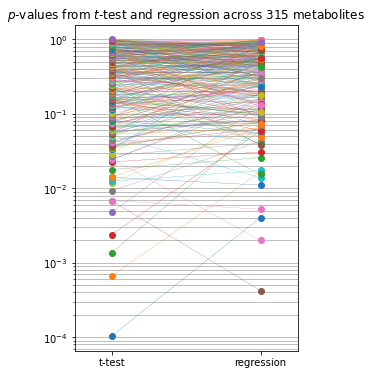

In [18]:
df = regsummary_t.loc[regsummary_t[('General', 'Dataset')] == 'blood']#.head(10)
fig, ax = plt.subplots(figsize=(4, 6))
for metabolite in df.index:
    p_reg = df.loc[metabolite, ('p', 'Age[A]:Q("LIscore cent.")')]
    p_tt = df.loc[metabolite, ('t-test', 'p')]
    ax.plot([-1, 1], [p_tt, p_reg], label=metabolite, marker='o', linewidth=0.25)

ax.set_yscale('log')
ax.set_xlim(-01.5, 1.5)
ax.set_xticks([-1, 1])
ax.set_xticklabels(['t-test', 'regression'])
ax.grid(axis='y', which='both')
ax.set_title(r'$p$-values from $t$-test and regression across ' + str(df.shape[0]) + ' metabolites')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'compare-t_test-regression-pval-blood')

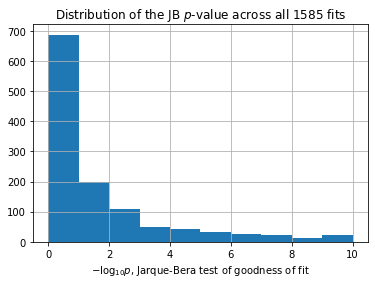

In [19]:
fig, ax = plt.subplots()
regsummary[('Goodness of fit', 'jbpv')].apply(lambda x: - np.log10(x)).hist(ax=ax, range=(0, 10))
ax.set_xlabel(r'$- \log_{10} p$, Jarque-Bera test of goodness of fit')
ax.set_title(r'Distribution of the JB $p$-value across all ' + str(regsummary.shape[0]) + ' fits')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'goodness-of-fit-jb-pval-hist')

In [20]:
%connect_info

{
  "shell_port": 61831,
  "iopub_port": 61832,
  "stdin_port": 61833,
  "control_port": 61835,
  "hb_port": 61834,
  "ip": "127.0.0.1",
  "key": "5d9d6f19-47362f634ee86730abb98fea",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-81925ee6-a856-4280-9a3c-4d9a71717b6d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
